# Q2: Cycle Generative Adversarial Network (CycleGAN)

In [1]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from library.visualizations.point_pairs import visualize_point_correspondence
from library.utils.numerical_checking import NumericalCheckingRecord
from library.utils.helper_functions import check_model_forward, plot_generated_samples, plot_samples
from flax import linen as nn
from jax import random, numpy as jnp
import optax
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

/home/trent/anaconda3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In the previous notebook, you saw how GAN tries to learn to generate samples from a desired distribution. In this notebook, you will use CycleGAN to learn how to map samples from one distribution to another. One of the key advantages of CycleGAN is that it does not require a paired dataset. Instead, it learns the sample-to-sample correspondence between two datasets by enforcing cycle consistency. In this homework, you will consider the mapping between two distributions of the blob dataset you saw in the GAN notebook. These are illustrated below.

In [2]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

# Create dataset
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B, n_clusters=1)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [3]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"), name='Real B'), row=1, col=2)
fig.update_layout(title_text="Real samples")
fig.show()

In [4]:
print(real_A.shape, real_B.shape)

(1000, 2) (1000, 2)


## Part (A): Initialize CycleGAN and interpret generated fake samples

Since you already learned how to create the discriminator and generator in the GAN notebook, you can reuse their architectures below. Remember that we have two different distributions now instead of one for GAN.

In [5]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])


In [6]:
# Initialize model with generators, discriminators and loss function.
modules = {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    }

model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [7]:
# Get generators from untrained model and draw samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [8]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from untrained generators")
fig.show()

## Train with bidirectional cycle loss

In [17]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [18]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'None')

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7575; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7845; Discriminator A loss:  0.6589; Discriminator B loss:  0.7475: : 1it [00:01,  1.86s/it]
Epoch 1; Generator AB GAN loss:  0.6932; Generator BA GAN loss:  0.7817; Generator AB Cycle loss:  0.8256; Generator BA Cycle loss:  0.7418; Discriminator A loss:  0.6475; Discriminator B loss:  0.7357: : 1it [00:00,  4.22it/s]
Epoch 2; Generator AB GAN loss:  0.6889; Generator BA GAN loss:  0.8082; Generator AB Cycle loss:  0.8219; Generator BA Cycle loss:  0.6991; Discriminator A loss:  0.6344; Discriminator B loss:  0.7249: : 1it [00:00,  4.22it/s]
Epoch 3; Generator AB GAN loss:  0.6858; Generator BA GAN loss:  0.8394; Generator AB Cycle loss:  0.8198; Generator BA Cycle loss:  0.6479; Discriminator A loss:  0.6198; Discriminator B loss:  0.7149: : 1it [00:00,  4.23it/s]
Epoch 4; Generator AB GAN loss:  0.6835; Generator BA GAN loss:  0.8758; Generator AB Cy

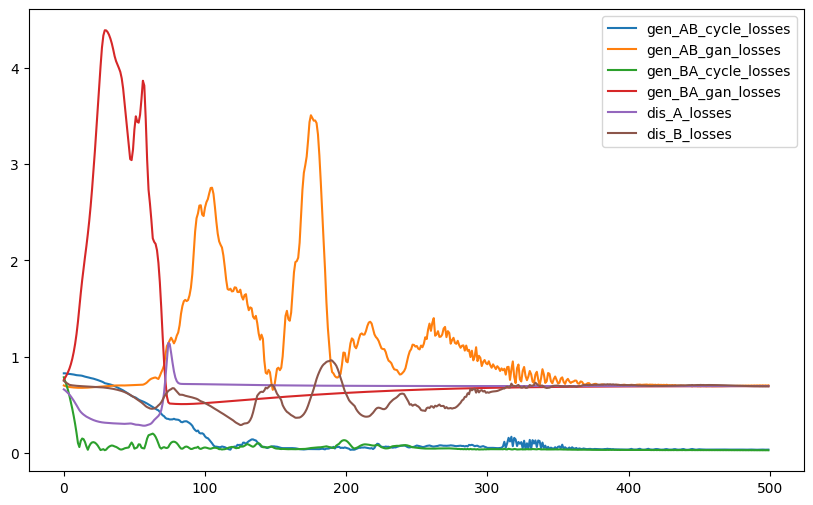

In [19]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [20]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.generator(real_B)
fake_B = gan_AB.generator(real_A)

In [21]:
px.scatter(x=real_A[:, 0], y=real_A[:, 1])

In [22]:
plot_generated_samples(real_A, real_B, fake_A, fake_B)

## Part (E): Ablation study with cycle-consistency loss
In this part, an ablation study is conducted on the impact of the cycle-consistency loss. In Part (B) you implemented cycle-consistency loss which consists of forward-consistency (from distribution A to B) and backward-consistency (from distribution B to A). In this part, you will conduct an ablation study examining the generator performance when only having forward-consistency. For your intuition, consider the cycle-consistency loss function.

$$\mathcal{L}_{cyc}(G_{AB}, G_{BA}) = \mathcal{L}_{forward}(G_{AB}) + \mathcal{L}_{backward}(G_{BA})$$
where 
\begin{align*}
\mathcal{L}_{forward}(G_{AB}, G_{BA}) &= \mathbb{E}_{a \sim p_{data}(a)}\left[||G_{BA}(G_{AB}(a))-a||_1\right] \\
\mathcal{L}_{backward}(G_{AB},G_{BA}) &= \mathbb{E}_{b \sim p_{data}(b)}\left[||G_{AB}(G_{BA}(b))-b||_1\right]
\end{align*}

### Train with ABA cycle loss only

In [25]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [26]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'BAB')

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7575; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7845; Discriminator A loss:  0.6589; Discriminator B loss:  0.7475: : 1it [00:01,  1.93s/it]
Epoch 1; Generator AB GAN loss:  0.6921; Generator BA GAN loss:  0.7651; Generator AB Cycle loss:  0.8220; Generator BA Cycle loss:  0.8123; Discriminator A loss:  0.6550; Discriminator B loss:  0.7360: : 1it [00:00,  4.03it/s]
Epoch 2; Generator AB GAN loss:  0.6883; Generator BA GAN loss:  0.7723; Generator AB Cycle loss:  0.8212; Generator BA Cycle loss:  0.8239; Discriminator A loss:  0.6516; Discriminator B loss:  0.7250: : 1it [00:00,  3.32it/s]
Epoch 3; Generator AB GAN loss:  0.6860; Generator BA GAN loss:  0.7776; Generator AB Cycle loss:  0.8155; Generator BA Cycle loss:  0.8258; Discriminator A loss:  0.6480; Discriminator B loss:  0.7149: : 1it [00:00,  3.91it/s]
Epoch 4; Generator AB GAN loss:  0.6839; Generator BA GAN loss:  0.7810; Generator AB Cy

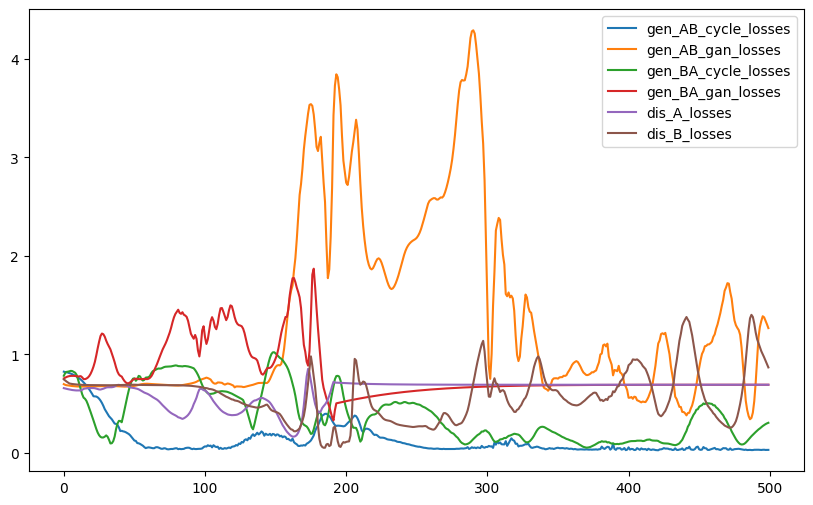

In [27]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [28]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.generator(real_B)
fake_B = gan_AB.generator(real_A)

In [29]:
plot_generated_samples(real_A, real_B, fake_A, fake_B)

In [30]:
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue", size=2.5),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green", size=2.5),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=recon_A[:, 0], y=recon_A[:, 1], mode='markers', marker=dict(color="red", size=2.5),name='recon_A'), row=1, col=1)
fig.add_trace(go.Scatter(x=recon_B[:, 0], y=recon_B[:, 1], mode='markers', marker=dict(color="purple", size=2.5),name='recon_B'), row=1, col=2)
fig.update_layout(title_text="Real samples and reconstructed samples from the trained generators")
fig.show()

### Train with BAB cycle loss only

In [33]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [35]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'ABA')

Epoch 0; Generator AB GAN loss:  0.6799; Generator BA GAN loss:  1.9457; Generator AB Cycle loss:  2.7516; Generator BA Cycle loss:  0.0407; Discriminator A loss:  0.3977; Discriminator B loss:  0.6932: : 1it [00:01,  1.89s/it]
Epoch 1; Generator AB GAN loss:  0.6823; Generator BA GAN loss:  1.8128; Generator AB Cycle loss:  2.6487; Generator BA Cycle loss:  0.0563; Discriminator A loss:  0.3908; Discriminator B loss:  0.6932: : 1it [00:00,  4.02it/s]
Epoch 2; Generator AB GAN loss:  0.6848; Generator BA GAN loss:  1.7608; Generator AB Cycle loss:  2.5156; Generator BA Cycle loss:  0.0442; Discriminator A loss:  0.3895; Discriminator B loss:  0.6932: : 1it [00:00,  4.06it/s]
Epoch 3; Generator AB GAN loss:  0.6872; Generator BA GAN loss:  1.7478; Generator AB Cycle loss:  2.4515; Generator BA Cycle loss:  0.0529; Discriminator A loss:  0.3896; Discriminator B loss:  0.6932: : 1it [00:00,  4.10it/s]
Epoch 4; Generator AB GAN loss:  0.6895; Generator BA GAN loss:  1.7529; Generator AB Cy

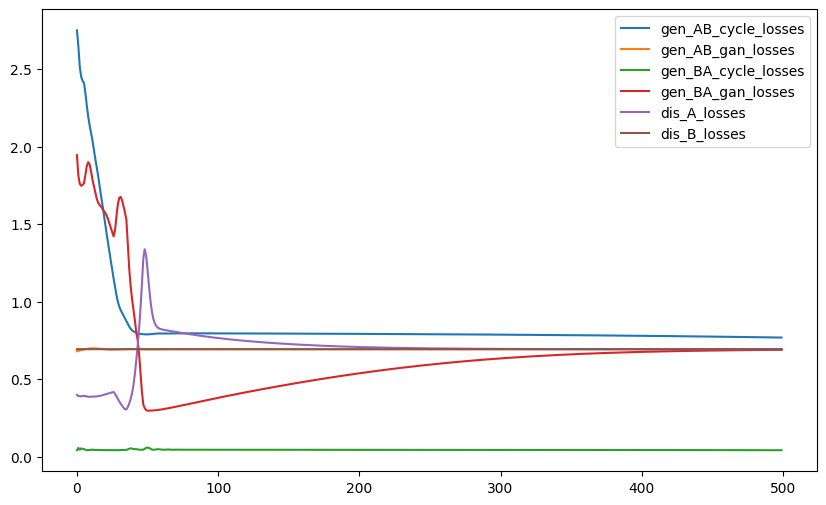

In [36]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [37]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.generator(real_B)
fake_B = gan_AB.generator(real_A)

In [38]:
plot_generated_samples(real_A, real_B, fake_A, fake_B)

In [39]:
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue", size=2.5),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green", size=2.5),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=recon_A[:, 0], y=recon_A[:, 1], mode='markers', marker=dict(color="red", size=2.5),name='recon_A'), row=1, col=1)
fig.add_trace(go.Scatter(x=recon_B[:, 0], y=recon_B[:, 1], mode='markers', marker=dict(color="purple", size=2.5),name='recon_B'), row=1, col=2)
fig.update_layout(title_text="Real samples and reconstructed samples from the trained generators")
fig.show()